In [1]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img,load_img
from keras.models import Sequential, Model
from keras.models import load_model
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

Using TensorFlow backend.


In [2]:
path="Dataset/"

In [3]:
metaData=pd.read_excel(path+"styles.xlsx")
print(metaData.columns)

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')


# Preprocessing Dataset For Gender Data

In [4]:
final=metaData.loc[metaData['masterCategory'].isin(['Accessories','Apparel','Footwear'])]
print(final.gender.value_counts())

Men       21519
Women     16767
Unisex     2112
Boys        830
Girls       655
Name: gender, dtype: int64


In [5]:
final.loc[final['gender'] =='Boys',"gender"]="Men"
final.loc[final['gender'] =='Girls',"gender"]="Women"
print(final.gender.value_counts())

Men       22349
Women     17422
Unisex     2112
Name: gender, dtype: int64


C:\Users\lenovo\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [6]:
X=[(str(x)+".jpg") for x in final["id"]]
Y=final['gender']

In [7]:
X_train,X_test,Y_train,Y_test=train_test_split(X, Y, test_size=0.33, stratify=Y)

In [8]:
preprocess=ImageDataGenerator(rescale=1./255)
traindf=pd.DataFrame(np.column_stack([X_train,Y_train]), columns=['FileName', 'gender'])
testdf=pd.DataFrame(np.column_stack([X_test,Y_test]), columns=['FileName', 'gender'])

In [9]:
print(traindf.head())
print(testdf.head())
batch_size=100

    FileName gender
0  54573.jpg  Women
1  17498.jpg    Men
2  54637.jpg    Men
3  34734.jpg  Women
4  14282.jpg  Women
    FileName  gender
0  19634.jpg   Women
1   7092.jpg  Unisex
2  14858.jpg   Women
3  11058.jpg     Men
4  29011.jpg     Men


In [10]:
trainData = preprocess.flow_from_dataframe(
    dataframe=traindf,
    directory=path+'images/',
    x_col = 'FileName',
    y_col = 'gender',
    target_size = (64,64),
    batch_size=batch_size,
    shuffle=False
 )

Found 28061 validated image filenames belonging to 3 classes.


In [12]:
with tf.device('/GPU:0'):
    testData = preprocess.flow_from_dataframe(
        dataframe=testdf, 
        directory=path+'images/',
        x_col = 'FileName', 
        y_col = 'gender', 
        target_size = (64,64),
        batch_size=1,
        shuffle=False
    )

Found 13822 validated image filenames belonging to 3 classes.


# Model Creation

In [13]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(64,64,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))
# model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
# model.add(LeakyReLU(alpha=0.1))                  
# model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(64, activation='linear'))
model.add(LeakyReLU(alpha=0.1))           
model.add(Dropout(0.3))
model.add(Dense(len(trainData.class_indices), activation='softmax'))
print(model.summary())


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/t

# Model compile and train

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("Models/gender_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')


Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0


In [15]:
start = time.time()
hist = model.fit_generator(
    generator=trainData, 
    steps_per_epoch=int(np.ceil(trainData.n/batch_size)), 
    validation_data=testData, 
    validation_steps=int(np.ceil(testData.n/batch_size)),
    epochs=20,
    callbacks=[checkpoint,early],
    verbose=1
  )
end = time.time()
print('Time:',(end - start)/60)

Executing op Reshape in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 1/20
Executing op __inference_keras_scratch_graph_1403 in device /job:localhost/replica:0/task:0/device:GPU:0
281/281 [==============================] - 1624s 6s/step - loss: 0.5406 - accuracy: 0.7784 - val_loss: 0.1914 - val_accuracy: 0.8633

Epoch 00001: val_accuracy improved from -inf to 0.86331, saving model to Models/gender_model.h5
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
Epoch 2/20
281/281 [==============================] - 293s 1s/step - loss: 0.3824 - accuracy: 0.8552 - val_loss: 0.0537 - val_accuracy: 0.9137

Epoch 00002: val_accuracy improved

# Model Evaluate

In [16]:
model_evaluate=model.evaluate_generator(generator=testData,verbose=1)
print('Test loss:', model_evaluate[0])
print('Test accuracy:', model_evaluate[1])

13822/13822 [==============================] - 624s 45ms/step
Test loss: 0.0
Test accuracy: 0.910143256187439


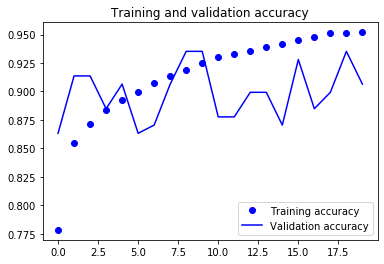

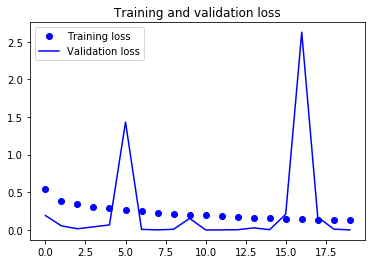

In [17]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Prediction on test Dataset

In [43]:
predict_test=model.predict_generator(generator=testData,verbose=1)

13822/13822 [==============================] - 72s 5ms/step


In [44]:
predicted_testclasses = np.argmax(predict_test, axis=1)

In [45]:
true_testclasses = testData.classes

In [46]:
print(classification_report(true_testclasses,predicted_testclasses))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93      7375
           1       0.67      0.48      0.56       697
           2       0.93      0.91      0.92      5750

    accuracy                           0.91     13822
   macro avg       0.84      0.78      0.80     13822
weighted avg       0.91      0.91      0.91     13822



# Prediction on Train Dataset

In [22]:
predict_train=model.predict_generator(generator=trainData,verbose=1)

183/281 [==================>...........] - ETA: 1:07

C:\Users\lenovo\Anaconda3\lib\site-packages\keras\utils\data_utils.py:616: UserWarning: The input 183 could not be retrieved. It could be because a worker has died.
  UserWarning)


281/281 [==============================] - 211s 750ms/step


In [23]:
predicted_trainClasses = np.argmax(predict_train, axis=1)

In [24]:
true_trainclasses = trainData.classes

In [25]:
print(classification_report(true_trainclasses,predicted_trainClasses))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     14974
           1       0.98      0.87      0.92      1415
           2       0.99      0.98      0.98     11672

    accuracy                           0.98     28061
   macro avg       0.98      0.95      0.96     28061
weighted avg       0.98      0.98      0.98     28061



# Feature Extraction

In [27]:
feature_model = Model(inputs=model.inputs,outputs=model.get_layer('leaky_re_lu_3').output)
feature_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0   

In [28]:
train_feature=feature_model.predict_generator(trainData,verbose=1)
train_feature=pd.DataFrame(train_feature)

Executing op __inference_keras_scratch_graph_177590 in device /job:localhost/replica:0/task:0/device:GPU:0
281/281 [==============================] - 90s 319ms/step


In [29]:
test_feature=feature_model.predict_generator(testData,verbose=1)
test_feature=pd.DataFrame(test_feature)

13822/13822 [==============================] - 69s 5ms/step


In [32]:
train_feature.columns
test_feature.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46',
       '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58',
       '59', '60', '61', '62', '63'],
      dtype='object')

In [34]:
test_feature = pd.concat([testdf,test_feature], axis =1)
train_feature = pd.concat([traindf,train_feature], axis =1)

In [35]:
print(test_feature.head())
print(train_feature.head())

    FileName  gender         0         1         2         3         4  \
0  19634.jpg   Women -0.132837 -0.609280  5.967240 -0.283872 -0.133579   
1   7092.jpg  Unisex -0.170861 -0.158958 -0.382392 -0.069160 -0.405637   
2  14858.jpg   Women -0.446347  1.943702 -0.127529  2.776503 -0.110135   
3  11058.jpg     Men  3.235393  3.566104 -0.132156  2.600274  9.771614   
4  29011.jpg     Men  4.611821 -0.251916 -0.153361 -0.073425  7.260854   

          5         6         7  ...        54        55        56        57  \
0 -0.438107 -0.653195 -0.475299  ... -0.189794 -0.682738  3.917785 -0.005261   
1  2.702091  2.842383 -0.293132  ... -0.258333 -0.020025 -0.139591 -0.345986   
2 -0.319593 -0.759647  0.954713  ... -0.097764  2.766940 -0.555861 -0.229967   
3 -0.569992 -0.671537  5.950741  ... -0.491596 -0.342698 -0.322562  5.244507   
4  0.349912 -0.966692  6.648393  ... -0.574005 -0.709595 -0.449382  5.439957   

         58        59        60        61        62        63  
0 -0.52455

In [36]:
train_feature.to_csv('Features/gender_train_feature.csv', index = False, header=True)
test_feature.to_csv('Features/gender_test_feature.csv', index = False, header=True)

In [37]:
tr=pd.read_csv('Features/gender_train_feature.csv')
te=pd.read_csv('Features/gender_test_feature.csv')
tr.columns
te.columns

Index(['FileName', 'gender', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45',
       '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57',
       '58', '59', '60', '61', '62', '63'],
      dtype='object')

In [38]:
te.head()

,FileName,gender,0,1,2,3,4,5,6,7,...,54,55,56,57,58,59,60,61,62,63
0,19634.jpg,Women,-0.132837,-0.609280,5.967240,-0.283872,-0.133579,-0.438107,-0.653195,-0.475299,...,-0.189794,-0.682738,3.917785,-0.005261,-0.524553,-0.061034,1.829298,-0.933475,-0.966815,1.205960
1,7092.jpg,Unisex,-0.170861,-0.158958,-0.382392,-0.069160,-0.405637,2.702091,2.842383,-0.293132,...,-0.258333,-0.020025,-0.139591,-0.345986,-0.587658,-0.371933,2.544652,1.522076,0.006266,-0.166679
2,14858.jpg,Women,-0.446347,1.943702,-0.127529,2.776503,-0.110135,-0.319593,-0.759647,0.954713,...,-0.097764,2.766940,-0.555861,-0.229967,-0.350426,-0.387605,-0.474839,-0.498970,-0.043681,-0.543084
3,11058.jpg,Men,3.235393,3.566104,-0.132156,2.600274,9.771614,-0.569992,-0.671537,5.950741,...,-0.491596,-0.342698,-0.322562,5.244507,-1.016179,-0.202539,0.782958,-0.767531,-0.590757,-0.014841
4,29011.jpg,Men,4.611821,-0.251916,-0.153361,-0.073425,7.260854,0.349912,-0.966692,6.648393,...,-0.574005,-0.709595,-0.449382,5.439957,-1.170821,-0.851284,-0.088853,-0.910798,-0.664750,-0.467341


In [39]:
mod=load_model('Models/gender_model.h5')
print(mod.summary())

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
________________________________________________________

In [47]:
feature_model.summary()
feature_model.save('Models/gender_featureExtractor.h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0   

In [48]:
fmod=load_model('Models/gender_featureExtractor.h5')
fmod.summary()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
___________